<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/subspace_mlp_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subspace training of an MLP

In [1]:
%%capture
!pip install optax
!pip install flax

In [2]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from jax import random
from functools import partial
from flax.training import train_state
from jax.scipy.optimize import minimize
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [3]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
%config InlineBackend.figure_format = "retina"
#%load_ext line_profiler
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# training_utils.py
https://github.com/gerdm/probml-research/blob/main/scripts/training_utils.py


In [5]:
# Original code taken from https://github.com/ganguli-lab/degrees-of-freedom

import numpy as onp  # original numpy
import jax.numpy as jnp  # jax numpy
import itertools
from jax import jit, grad, random
import jax


def generate_projection(d, D, k_nonzero=None, enforce_no_overlap_if_possible=True):

    M_random = onp.random.normal(loc=0.0, scale=1.0, size=(d, D))

    if k_nonzero is None:  # no conditions on axis alignment
        M_now = M_random
    else:
        M_now = onp.zeros((d, D))

        if (k_nonzero * d <= D) and (enforce_no_overlap_if_possible == True):
            ids_flat = onp.random.choice(range(D), (k_nonzero * d), replace=False)
            ids_shaped = ids_flat.reshape([d, k_nonzero])
        elif (k_nonzero * d <= D) and (enforce_no_overlap_if_possible == False):
            ids_flat = onp.random.choice(range(D), (k_nonzero * d), replace=True)
            ids_shaped = ids_flat.reshape([d, k_nonzero])
        else:
            ids_flat = onp.random.choice(range(D), (k_nonzero * d), replace=True)
            ids_shaped = ids_flat.reshape([d, k_nonzero])

        for i in range(d):
            M_now[i, ids_shaped[i]] = M_random[i, ids_shaped[i]]

    # normalization to unit length of each basis vector
    M_now = M_now / onp.linalg.norm(M_now, axis=-1, keepdims=True)

    return M_now


## These are the functions required for doing optimization in the hyperplane
@jit
def flatten_leaves(leaves):
    shapes_list = []
    vals_list = []
    for leaf in leaves:
        shapes_list.append(leaf.shape)
        vals_list.append(leaf.reshape([-1]))
    return jnp.concatenate(vals_list), shapes_list


def reform_leaves(vec, shapes_list):
    counter = 0
    leaves = []
    for shape in shapes_list:
        shape = jnp.asarray(shape)
        step = jnp.prod(shape)
        leaves.append((vec[counter : counter + step]).reshape(shape))
        counter = counter + step
    return leaves


@jit
def theta_to_flat_params(theta, M, flat_params0):
    return jnp.matmul(theta, M)[0] + flat_params0


def theta_to_paramstree(theta, M, flat_params0, treedef, shapes_list):
    flat_params = theta_to_flat_params(theta, M, flat_params0)
    leaves = reform_leaves(flat_params, shapes_list)
    return jax.tree_unflatten(treedef, leaves)

In [ ]:
'''
# Sparse matrix vector multiplication
@jax.partial(jax.jit, static_argnums=(2))
def sp_matmul(A, B, D):
	"""
	Arguments:
		A: (N, M) sparse matrix represented as a tuple (indexes, values)
		B: (M,K) dense matrix
		D: value of N, full weight space dimension
	Returns:
		(N, K) dense matrix
	Modified from: 
		https://gcucurull.github.io/deep-learning/2020/06/03/jax-sparse-matrix-multiplication/
	"""
	assert B.ndim == 2
	rows, cols, values = A
	in_ = B.take(cols.astype('int32'), axis=0)
	prod = in_*values[:, None]
	res = jax.ops.segment_sum(prod, rows.astype('int32'), D)
	return res

#Same functions as above, but using sparse matrix multiplications
@jit
def sparse_theta_to_flat_params(theta,M,flat_params0):	
	MTthetaT = sp_matmul(M,theta.T,flat_params0.shape[0])
	return MTthetaT.T[0] + flat_params0

def sparse_theta_to_paramstree(theta,M,flat_params0,treedef,shapes_list):
	flat_params = sparse_theta_to_flat_params(theta,M,flat_params0)
	leaves = reform_leaves(flat_params,shapes_list)
	return jax.tree_unflatten(treedef,leaves)
'''

## MNIST

In [6]:
from time import time
import tensorflow_datasets as tfds

In [7]:
import sys

# sys.path.append("../scripts/")
# import training_utils

In [8]:
def get_datasets():
    """
    Load MNIST train and test datasets into memory
    """
    ds_builder = tfds.builder("mnist")
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split="train", batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split="test", batch_size=-1))
    train_ds["image"] = jnp.float32(train_ds["image"]) / 255.0
    test_ds["image"] = jnp.float32(test_ds["image"]) / 255.0
    return train_ds, test_ds

In [9]:
train_ds, test_ds = get_datasets()
train_ds["image"] = train_ds["image"].reshape(-1, 28**2)
test_ds["image"] = test_ds["image"].reshape(-1, 28**2)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [10]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(784)(x))
        x = nn.relu(nn.Dense(200)(x))
        x = nn.relu(nn.Dense(200)(x))
        x = nn.Dense(10)(x)
        return nn.log_softmax(x)

In [11]:
@jax.vmap
def cross_entropy_loss(logits, label):
    return -logits[label]


@jax.jit
def normal_loss(params, batch):
    logits = MLP().apply({"params": params}, batch["image"])
    logits = jax.nn.log_softmax(logits)
    loss = jnp.mean(cross_entropy_loss(logits, batch["label"]))
    return loss


@jax.jit
def normal_accuracy(params, batch):
    logits = MLP().apply({"params": params}, batch["image"])
    logits = jax.nn.log_softmax(logits)
    return jnp.mean(jnp.argmax(logits, -1) == batch["label"])

In [12]:
key = random.PRNGKey(314)
init_params = MLP().init(key, train_ds["image"][[0], :])["params"]
theta0, reconstruct_tree_params = jax.flatten_util.ravel_pytree(init_params)

In [13]:
%%time
D = len(theta0)
d = 100  # 1200
M = jnp.array(generate_projection(d, D))

CPU times: user 3.76 s, sys: 430 ms, total: 4.19 s
Wall time: 4.16 s


In [14]:
@jax.jit
def project_subspace(theta_flat, M, theta0_flat):
    return jnp.matmul(theta_flat, M)[0] + theta0_flat


def projected_loss(theta_subspace, batch, M, theta0):
    """
    1. Project theta_subspace ∈ R^d => theta ∈ R^D
    2. Compute loss of the model w.r.t. theta_subspace
    """
    projected_subspace_params = project_subspace(theta_subspace, M, theta0)
    projected_subspace_params = reconstruct_tree_params(projected_subspace_params)
    return normal_loss(projected_subspace_params, batch)


loss_grad_wrt_theta = jax.grad(projected_loss)


@jax.jit
def adam_update(grads, params, mass, velocity, hyperparams):

    mass = hyperparams["beta_1"] * mass + (1.0 - hyperparams["beta_1"]) * grads
    velocity = hyperparams["beta_2"] * velocity + (1.0 - hyperparams["beta_2"]) * (grads**2.0)
    # Bias correction
    hat_mass = mass / (1 - hyperparams["beta_1"])
    hat_velocity = velocity / (1 - hyperparams["beta_2"])
    # Update
    params = params - hyperparams["lr"] / (jnp.sqrt(hat_velocity) + hyperparams["epsilon"]) * hat_mass

    return params, mass, velocity

In [15]:
def mlp_subspace_train(theta0, M, train_ds, test_ds, n_epochs, hyperparams, logline=100, print_status=True):
    d, D = M.shape

    theta = jnp.zeros((1, d))
    mass = jnp.zeros((1, d))
    velocity = jnp.zeros((1, d))

    projected_loss_part = partial(projected_loss, M=M, theta0=theta0)
    loss_grad_wrt_theta = jax.grad(projected_loss_part)

    for e in range(n_epochs):
        grads = loss_grad_wrt_theta(theta, train_ds)
        theta, mass, velocity = adam_update(grads, theta, mass, velocity, hyperparams)

        params_now = project_subspace(theta, M, theta0)
        params_now = reconstruct_tree_params(params_now)

        epoch_loss = normal_loss(params_now, train_ds)
        epoch_accuracy = normal_accuracy(params_now, train_ds)

        if e % logline == 0 or e == n_epochs - 1:
            end = "\n"
            epoch_val_accuracy = normal_accuracy(params_now, test_ds)
            val_str = f" || val acc: {epoch_val_accuracy:0.2%}"
        else:
            end = "\r"
            val_str = ""
        metric_str = f"epoch: {e+1:03} || acc: {epoch_accuracy:0.2%} || loss:{epoch_loss:0.2f}"
        metric_str += val_str
        if print_status:
            print(metric_str, end=end)

    epoch_val_loss = normal_loss(params_now, test_ds)
    return theta, epoch_val_accuracy, epoch_val_loss

### Training subspace

In [16]:
d_max = 800  # 1200
# d_test = jnp.arange(0, 1200 + 20, 20)
d_test = jnp.arange(0, d_max + 200, 200)
d_test = jax.ops.index_update(d_test, 0, 2)

In [21]:
print(d_test)

[  2 200 400 600 800]


In [17]:
%%time
M = jnp.array(generate_projection(d_max, D))

CPU times: user 30.2 s, sys: 3.33 s, total: 33.6 s
Wall time: 33.4 s


In [18]:
print(M.shape)

(800, 814650)


In [23]:
val_acc_hist = []
val_loss_hist = []

n_epochs = 300

hyperparams = {"lr": 1e-1, "beta_1": 0.9, "beta_2": 0.999, "epsilon": 1e-7}


for d in d_test:
    print(f"\nTesting subpace {d}")
    t_init = time()
    _, val_acc, val_loss = mlp_subspace_train(theta0, M[:d], train_ds, test_ds, n_epochs, hyperparams)
    t_end = time()
    print(f"Total run: {t_end - t_init:0.2f}s")
    val_acc_hist.append(val_acc.item())
    val_loss_hist.append(val_loss.item())


Testing subpace 2
epoch: 001 || acc: 10.21% || loss:2.31 || val acc: 10.75%
epoch: 101 || acc: 10.99% || loss:2.29 || val acc: 11.22%
epoch: 201 || acc: 12.70% || loss:2.28 || val acc: 12.37%
epoch: 300 || acc: 12.86% || loss:2.28 || val acc: 12.53%
Total run: 27.23s

Testing subpace 200
epoch: 001 || acc: 11.83% || loss:2.30 || val acc: 12.30%
epoch: 101 || acc: 70.49% || loss:0.92 || val acc: 70.51%
epoch: 201 || acc: 74.33% || loss:0.80 || val acc: 74.57%
epoch: 300 || acc: 75.53% || loss:0.77 || val acc: 75.89%
Total run: 14.60s

Testing subpace 400
epoch: 001 || acc: 13.63% || loss:2.29 || val acc: 14.13%
epoch: 101 || acc: 83.60% || loss:0.53 || val acc: 84.31%
epoch: 201 || acc: 85.00% || loss:0.49 || val acc: 85.43%
epoch: 300 || acc: 85.36% || loss:0.48 || val acc: 85.87%
Total run: 15.27s

Testing subpace 600
epoch: 001 || acc: 15.08% || loss:2.29 || val acc: 15.33%
epoch: 101 || acc: 87.80% || loss:0.40 || val acc: 87.85%
epoch: 201 || acc: 88.94% || loss:0.37 || val acc: 8

Text(0, 0.5, 'Validation accuracy')

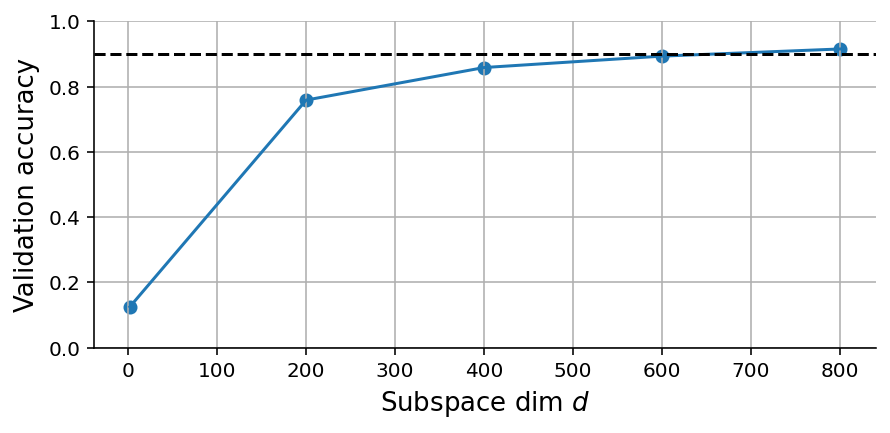

In [25]:
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(d_test, val_acc_hist)
plt.scatter(d_test, val_acc_hist)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid()
plt.axhline(y=0.9, c="black", linestyle="--")
plt.xlabel("Subspace dim $d$", fontsize=13)
plt.ylabel("Validation accuracy", fontsize=13)